In [1]:
#IMimport pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
import torch


In [3]:
# Load the D_ITEMS table
d_items = pd.read_csv('D_ITEMS.csv.gz')

# Preview
d_items.head()



,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,458,498,PCA Lockout (Min),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,459,499,PCA Medication,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3,460,500,PCA Total Dose,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4,461,501,PCV Exh Vt (Obser),NaN,carevue,chartevents,NaN,NaN,NaN,NaN


In [4]:
# Overview and missing values
d_items.info()
missing = d_items.isnull().sum()
print(missing[missing > 0])

# Duplicates
print(f"Total duplicate rows: {d_items.duplicated().sum()}")
d_items.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12487 entries, 0 to 12486
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ROW_ID        12487 non-null  int64  
 1   ITEMID        12487 non-null  int64  
 2   LABEL         12483 non-null  object 
 3   ABBREVIATION  2992 non-null   object 
 4   DBSOURCE      12487 non-null  object 
 5   LINKSTO       12487 non-null  object 
 6   CATEGORY      6049 non-null   object 
 7   UNITNAME      851 non-null    object 
 8   PARAM_TYPE    2992 non-null   object 
 9   CONCEPTID     0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 975.7+ KB
LABEL               4
ABBREVIATION     9495
CATEGORY         6438
UNITNAME        11636
PARAM_TYPE       9495
CONCEPTID       12487
dtype: int64
Total duplicate rows: 0


In [5]:
# Encode 'LABEL' and 'CATEGORY'
d_items['LABEL_CAT'] = d_items['LABEL'].astype('category').cat.codes
d_items['CATEGORY_CAT'] = d_items['CATEGORY'].astype('category').cat.codes


In [6]:
d_items_cleaned = d_items.copy()
d_items_cleaned.to_csv('d_items_cleaned.csv', index=False)


In [7]:
!pip install sdv

import sdv
print(sdv.__version__)

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
1.24.1


In [8]:
# Fix multiprocessing
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

# Load cleaned version
d_items_cleaned = pd.read_csv('d_items_cleaned.csv')

# Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(d_items_cleaned)

# Synthesizer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=30)
synthesizer.fit(d_items_cleaned)


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
ITEMID                 11
LABEL                  11847
ABBREVIATION           2908
DBSOURCE               3
LINKSTO                7
CATEGORY               95
UNITNAME               53
PARAM_TYPE             8
CONCEPTID              11
LABEL_CAT              11
CATEGORY_CAT           11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)


KeyboardInterrupt: 

In [9]:
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv('synthetic_d_items.csv', index=False)
synthetic_data.head()


SamplingError: This synthesizer has not been fitted. Please fit your synthesizer first before sampling synthetic data.

In [2]:
column = 'LABEL'
top_n = 20  # adjust as needed

# Get top N categories from real data
top_categories = d_items_cleaned[column].value_counts().nlargest(top_n).index

# Filter both datasets
real_top = d_items_cleaned[d_items_cleaned[column].isin(top_categories)]
synthetic_top = synthetic_data[synthetic_data[column].isin(top_categories)]

plt.figure(figsize=(14, 6))
sns.countplot(x=column, data=real_top, color='blue', label='Real', alpha=0.5)
sns.countplot(x=column, data=synthetic_top, color='red', label='Synthetic', alpha=0.5)
plt.title(f"Real vs Synthetic (Top {top_n} Categories): {column}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



NameError: name 'd_items_cleaned' is not defined

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Use LABEL_CAT and CATEGORY_CAT as features, target = above-median ITEMID
features = ['LABEL_CAT', 'CATEGORY_CAT']
target = 'ITEMID'

d_items_cleaned['target'] = (d_items_cleaned[target] > d_items_cleaned[target].median()).astype(int)
synthetic_data['target'] = (synthetic_data[target] > d_items_cleaned[target].median()).astype(int)

# Encode again in case
for col in features:
    d_items_cleaned[col] = d_items_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

# Real model
X_real = d_items_cleaned[features]
y_real = d_items_cleaned['target']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic model
X_syn = synthetic_data[features]
y_syn = synthetic_data['target']
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real D_ITEMS:     {real_acc:.2f}")
print(f" Model accuracy on synthetic D_ITEMS:{syn_acc:.2f}")


 Model accuracy on real D_ITEMS:     0.87
 Model accuracy on synthetic D_ITEMS:0.86


In [11]:
from sdv.single_table import TVAESynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and target (from D_CPT structure)
features = ['LABEL_CAT', 'CATEGORY_CAT']
target_col = 'ITEMID'

# Create binary classification target
d_items_cleaned['target'] = (d_items_cleaned[target_col] > d_items_cleaned[target_col].median()).astype(int)

# Regenerate metadata (if needed)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(d_items_cleaned.drop(columns=['target']))

# Fit TVAE (drop target column before fitting)
vae_synthesizer = TVAESynthesizer(metadata=metadata, epochs=300)
vae_synthesizer.fit(d_items_cleaned.drop(columns=['target']))

# Sample synthetic data
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

# Add target to synthetic data
synthetic_data_vae['target'] = (synthetic_data_vae[target_col] > d_items_cleaned[target_col].median()).astype(int)

# Encode categorical features
for col in features:
    d_items_cleaned[col] = d_items_cleaned[col].astype('category').cat.codes
    synthetic_data_vae[col] = synthetic_data_vae[col].astype('category').cat.codes

# Train/test split
X_real = d_items_cleaned[features]
y_real = d_items_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

# Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Results
print(f"Model accuracy on REAL D_CPT data: {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC D_CPT: {vae_acc:.2f}")


Model accuracy on REAL D_CPT data: 0.87
Model accuracy on VAE SYNTHETIC D_CPT: 0.85


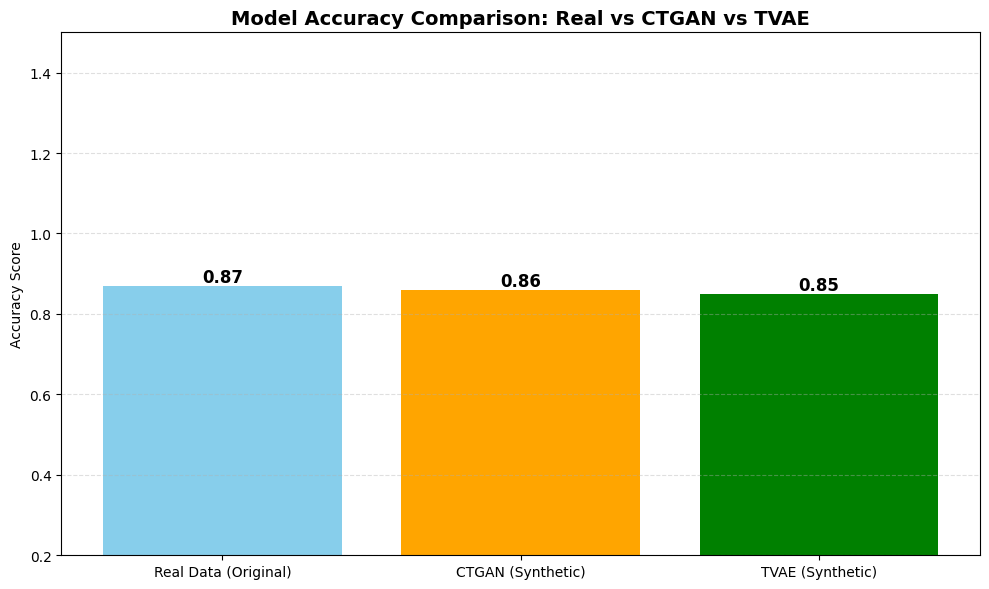

In [ ]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()